In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import pyodbc
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 1. Load data
conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=ALADINBH;'
    'DATABASE=Airline_DW;'
    'Trusted_Connection=yes;'
)

query = """
SELECT *
FROM FactClientF;
"""

df = pd.read_sql(query, conn)
print(df.head())
print("Raw data loaded:", df.shape)

   Member_fk   Date_fk  JoinDate_fk  CancellationDate_fk  Tier_fk  \
0       2321  20180801     20160801                  NaN        1   
1       4503  20170901     20130301                  NaN        2   
2       4381  20170401     20160701                  NaN        2   
3        168  20171201     20150801                  NaN        3   
4      14278  20180301     20140101                  NaN        3   

   Residency_fk  TotalFlights  Distance  PointsAccumulated  PointsRedeemed  \
0          23.0             0         0                  0               0   
1          21.0             3      5040               5040               0   
2          12.0             4      5272               5272               0   
3          27.0             3      7170               7170               0   
4          28.0             0         0                  0               0   

   DollarCostPointsRedeemed     CLV  
0                       0.0  7919.0  
1                       0.0  2887.0  
2 

In [4]:
# Create target variable: churned = 1 if CancellationDate_fk is not null, else 0
df['churned'] = df['CancellationDate_fk'].apply(lambda x: 1 if pd.notna(x) else 0)

# Drop identifier columns and date columns that won't be useful as features
# Keep Tier_fk as they might be categorical features
columns_to_drop = ['Member_fk', 'Date_fk', 'JoinDate_fk', 'CancellationDate_fk','Residency_fk']
df_features = df.drop(columns=columns_to_drop)

# Display target distribution
print("\n" + "="*50)
print("Target Distribution:")
print(df['churned'].value_counts())
print(f"\nChurn Rate: {(df['churned'].sum() / len(df) * 100):.2f}%")

# Check for missing values
print("\nMissing Values:")
print(df_features.isnull().sum())


Target Distribution:
churned
0    14670
1     2067
Name: count, dtype: int64

Churn Rate: 12.35%

Missing Values:
Tier_fk                     0
TotalFlights                0
Distance                    0
PointsAccumulated           0
PointsRedeemed              0
DollarCostPointsRedeemed    0
CLV                         0
churned                     0
dtype: int64


In [5]:
# Handle missing values if any
for col in df_features.columns:
    if df_features[col].isnull().sum() > 0 and col != 'churned':
        if df_features[col].dtype in ['int64', 'float64']:
            df_features[col].fillna(df_features[col].median(), inplace=True)
        else:
            df_features[col].fillna(df_features[col].mode()[0], inplace=True)

# Separate features and target
X = df_features.drop('churned', axis=1)
y = df_features['churned']

# Check feature types and encode categorical variables if needed
print("\n" + "="*50)
print("Feature Information:")
print("Feature set shape:", X.shape)
print("\nFeature data types:")
print(X.dtypes)


Feature Information:
Feature set shape: (16737, 7)

Feature data types:
Tier_fk                       int64
TotalFlights                  int64
Distance                      int64
PointsAccumulated             int64
PointsRedeemed                int64
DollarCostPointsRedeemed    float64
CLV                         float64
dtype: object


In [6]:
# If Tier_fk and Residency_fk are categorical, encode them
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    print(f"\nCategorical columns to encode: {list(categorical_cols)}")
    le = LabelEncoder()
    for col in categorical_cols:
        X[col] = le.fit_transform(X[col].astype(str))
else:
    # Check if Tier_fk and Residency_fk are numeric but represent categories
    potential_categorical = ['Tier_fk', 'Residency_fk']
    for col in potential_categorical:
        if col in X.columns:
            unique_values = X[col].nunique()
            print(f"\nColumn '{col}' has {unique_values} unique values")
            if unique_values < 20:  # If less than 20 unique values, treat as categorical
                print(f"  Treating '{col}' as categorical feature")

print("\n" + "="*50)
print("Prepared Data:")
print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFirst 5 rows of features:")
print(X.head())


Column 'Tier_fk' has 3 unique values
  Treating 'Tier_fk' as categorical feature

Prepared Data:
Features shape: (16737, 7)
Target shape: (16737,)

First 5 rows of features:
   Tier_fk  TotalFlights  Distance  PointsAccumulated  PointsRedeemed  \
0        1             0         0                  0               0   
1        2             3      5040               5040               0   
2        2             4      5272               5272               0   
3        3             3      7170               7170               0   
4        3             0         0                  0               0   

   DollarCostPointsRedeemed     CLV  
0                       0.0  7919.0  
1                       0.0  2887.0  
2                       0.0  2838.0  
3                       0.0  4170.0  
4                       0.0  6622.0  


In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n" + "="*50)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print(f"Training churn rate: {(y_train.sum() / len(y_train) * 100):.2f}%")
print(f"Testing churn rate: {(y_test.sum() / len(y_test) * 100):.2f}%")

# Initialize and train the decision tree model
dt_classifier = DecisionTreeClassifier(
    random_state=42,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced'
)

dt_classifier.fit(X_train, y_train)


Training set shape: (13389, 7)
Testing set shape: (3348, 7)
Training churn rate: 12.35%
Testing churn rate: 12.34%


,criterion,'gini'
,splitter,'best'
,max_depth,8
,min_samples_split,20
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'



=== Decision Tree Model Performance ===
Accuracy: 0.5529
ROC-AUC Score: 0.6150


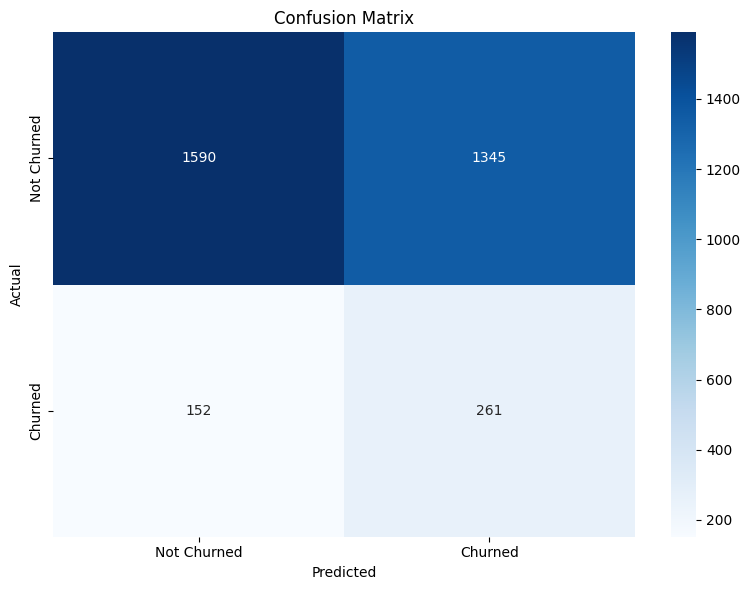

In [8]:
# Make predictions
y_pred = dt_classifier.predict(X_test)
y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n" + "="*50)
print("=== Decision Tree Model Performance ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [9]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*50)
print("Feature Importance:")
print(feature_importance)


Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.91      0.54      0.68      2935
     Churned       0.16      0.63      0.26       413

    accuracy                           0.55      3348
   macro avg       0.54      0.59      0.47      3348
weighted avg       0.82      0.55      0.63      3348


Feature Importance:
                    feature  importance
3         PointsAccumulated    0.470620
6                       CLV    0.241905
5  DollarCostPointsRedeemed    0.115417
2                  Distance    0.109543
1              TotalFlights    0.022332
4            PointsRedeemed    0.020749
0                   Tier_fk    0.019434


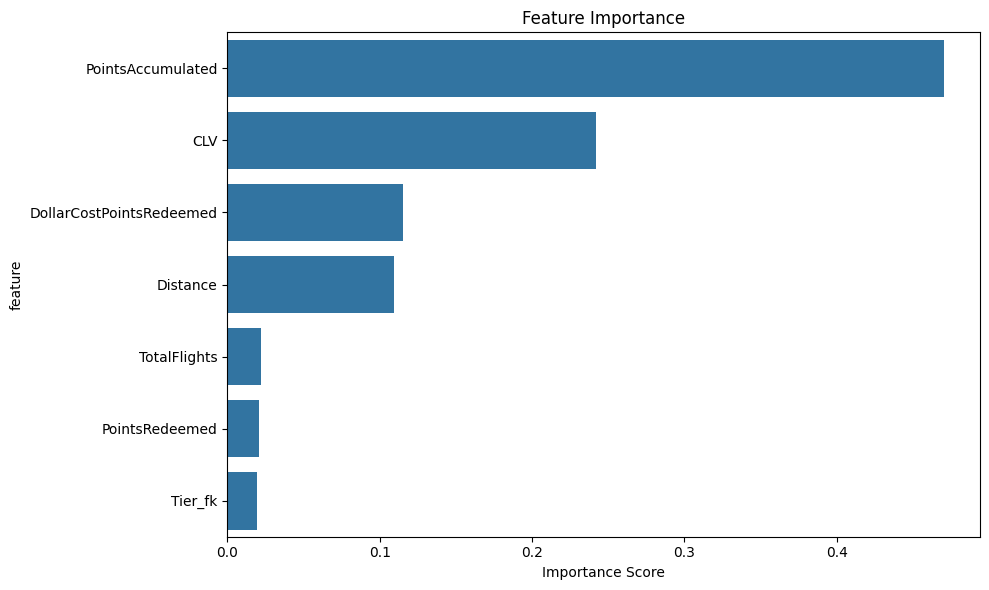

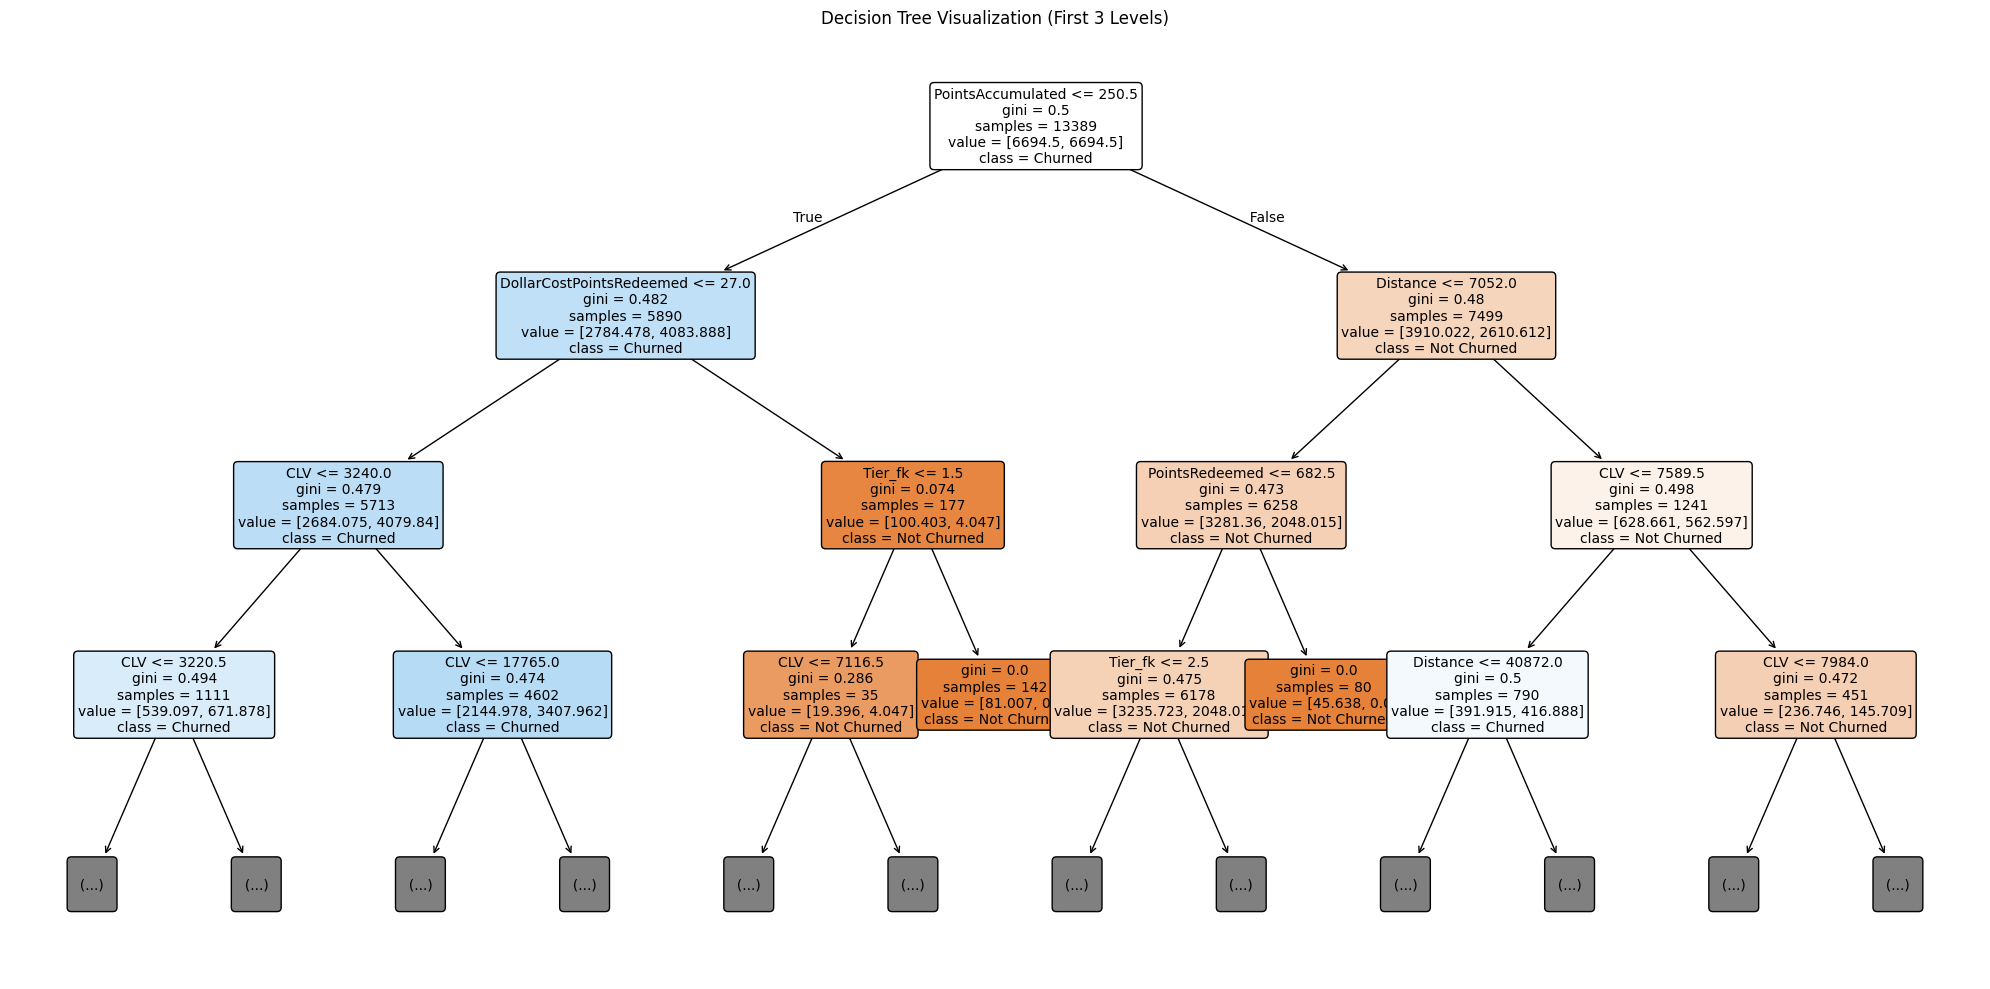

In [10]:
# Visualize top features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Visualize the decision tree (first 3 levels)
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier,
          feature_names=X.columns,
          class_names=['Not Churned', 'Churned'],
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=10)
plt.title('Decision Tree Visualization (First 3 Levels)')
plt.tight_layout()
plt.show()

In [11]:
# Hyperparameter Tuning with GridSearchCV
print("\n" + "="*50)
print("Performing Hyperparameter Tuning...")

param_grid = {
    'max_depth': [3, 5, 8, 10, 15],
    'min_samples_split': [10, 20, 30, 50],
    'min_samples_leaf': [5, 10, 15, 20],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))


Performing Hyperparameter Tuning...
Fitting 5 folds for each of 480 candidates, totalling 2400 fits

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10}
Best cross-validation score: 0.6098



=== Tuned Model Performance ===
Accuracy: 0.5896
ROC-AUC: 0.6078


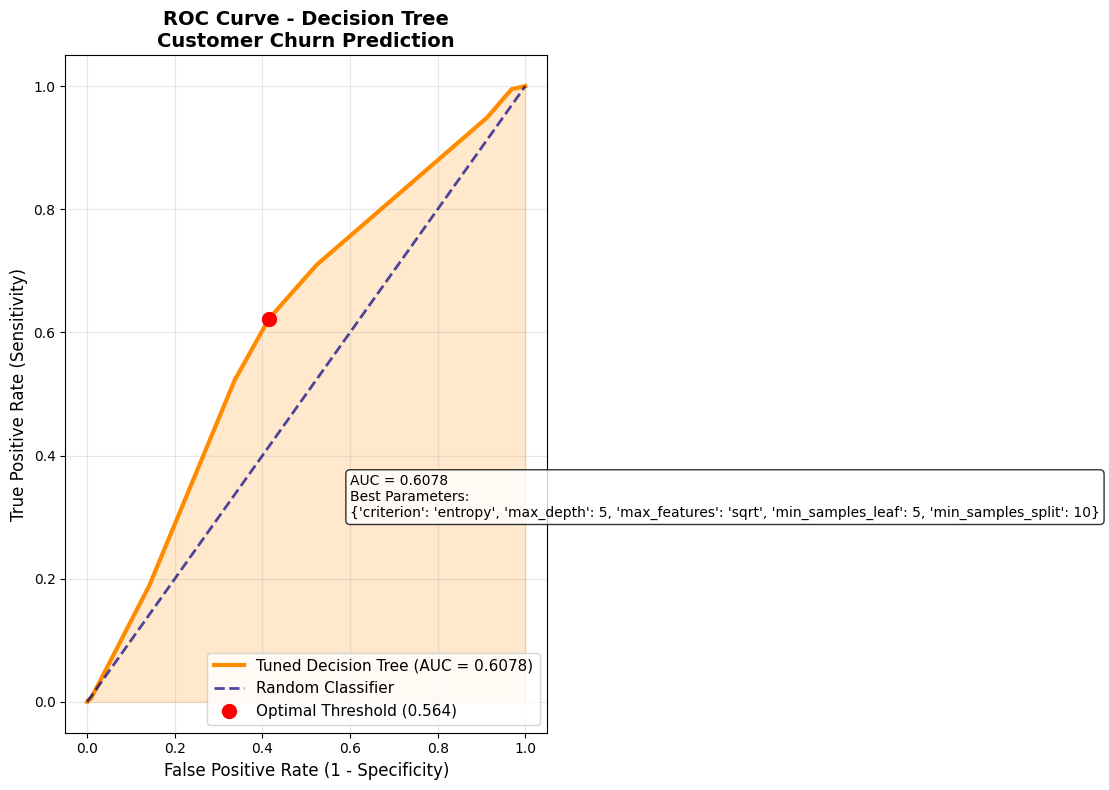


Best Model ROC-AUC: 0.6078
Optimal Threshold: 0.5639

BUSINESS INSIGHTS

Comparison between Churned and Retained Customers:
--------------------------------------------------

TotalFlights:
  Churned customers: 1.28
  Retained customers: 1.77
  Difference: -0.49

Distance:
  Churned customers: 1954.15
  Retained customers: 2652.73
  Difference: -698.58

PointsAccumulated:
  Churned customers: 2144.48
  Retained customers: 2882.69
  Difference: -738.21

PointsRedeemed:
  Churned customers: 19.01
  Retained customers: 43.57
  Difference: -24.56

DollarCostPointsRedeemed:
  Churned customers: 3.42
  Retained customers: 7.84
  Difference: -4.42

CLV:
  Churned customers: 8131.27
  Retained customers: 7968.27
  Difference: 163.01


In [12]:
# Evaluate the tuned model
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test)
y_pred_proba_best = best_dt.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("=== Tuned Model Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'Tuned Decision Tree (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.7, label='Random Classifier')
plt.fill_between(fpr, tpr, alpha=0.2, color='darkorange')

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10,
         label=f'Optimal Threshold ({optimal_threshold:.3f})')

plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curve - Decision Tree\nCustomer Churn Prediction', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

plt.text(0.6, 0.3, f'AUC = {roc_auc:.4f}\nBest Parameters:\n{grid_search.best_params_}',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
         fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nBest Model ROC-AUC: {roc_auc:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Business Insights - Compare churned vs retained customers
print("\n" + "="*50)
print("BUSINESS INSIGHTS")
print("="*50)

churned_customers = df_features[df_features['churned'] == 1]
non_churned_customers = df_features[df_features['churned'] == 0]

# Compare key metrics
print("\nComparison between Churned and Retained Customers:")
print("-" * 50)

metrics_to_compare = ['TotalFlights', 'Distance', 'PointsAccumulated',
                      'PointsRedeemed', 'DollarCostPointsRedeemed', 'CLV']

for metric in metrics_to_compare:
    if metric in df_features.columns:
        churned_mean = churned_customers[metric].mean()
        retained_mean = non_churned_customers[metric].mean()
        print(f"\n{metric}:")
        print(f"  Churned customers: {churned_mean:.2f}")
        print(f"  Retained customers: {retained_mean:.2f}")
        print(f"  Difference: {churned_mean - retained_mean:.2f}")



TIER ANALYSIS

Churn Rate by Tier:
Tier_fk
1    13.09
2    12.64
3    11.80
Name: churned, dtype: float64

Customer Distribution by Tier:
Tier_fk
3    7637
2    5671
1    3429
Name: count, dtype: int64


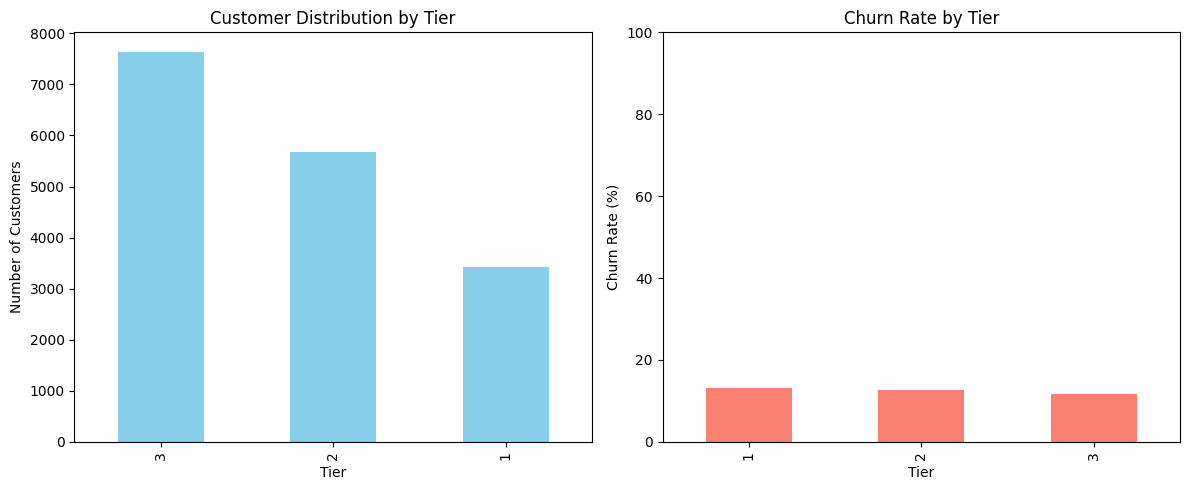


Feature importance results saved to 'feature_importance_results.csv'

SUMMARY OF KEY FINDINGS
1. Model achieved ROC-AUC of 0.6078
2. Optimal threshold for classification: 0.5639
3. Top 3 most important features:
   1. PointsAccumulated: 0.4706
   2. CLV: 0.2419
   3. DollarCostPointsRedeemed: 0.1154
4. Dataset churn rate: 12.35%


In [13]:
# Tier analysis if available
if 'Tier_fk' in df_features.columns:
    print("\n" + "="*50)
    print("TIER ANALYSIS")
    print("="*50)

    tier_churn_rate = df_features.groupby('Tier_fk')['churned'].mean() * 100
    tier_distribution = df_features['Tier_fk'].value_counts()

    print("\nChurn Rate by Tier:")
    print(tier_churn_rate.round(2))

    print("\nCustomer Distribution by Tier:")
    print(tier_distribution)

    # Visualize tier analysis
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Tier distribution
    tier_distribution.plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('Customer Distribution by Tier')
    axes[0].set_xlabel('Tier')
    axes[0].set_ylabel('Number of Customers')

    # Churn rate by tier
    tier_churn_rate.plot(kind='bar', ax=axes[1], color='salmon')
    axes[1].set_title('Churn Rate by Tier')
    axes[1].set_xlabel('Tier')
    axes[1].set_ylabel('Churn Rate (%)')
    axes[1].set_ylim([0, 100])

    plt.tight_layout()
    plt.show()

# Save important features to CSV
feature_importance.to_csv('feature_importance_results.csv', index=False)
print("\nFeature importance results saved to 'feature_importance_results.csv'")

# Print summary of most important features
print("\n" + "="*50)
print("SUMMARY OF KEY FINDINGS")
print("="*50)
print(f"1. Model achieved ROC-AUC of {roc_auc:.4f}")
print(f"2. Optimal threshold for classification: {optimal_threshold:.4f}")
print(f"3. Top 3 most important features:")
for i, (feature, importance) in enumerate(zip(feature_importance['feature'].head(3),
                                              feature_importance['importance'].head(3)), 1):
    print(f"   {i}. {feature}: {importance:.4f}")
print(f"4. Dataset churn rate: {(df['churned'].sum() / len(df) * 100):.2f}%")

In [14]:
import joblib

# Save the tuned best model (from GridSearchCV)
joblib.dump(best_dt, r"C:\MLModels\churn_dt_model.pkl")
print("Saved churn model at C:\\MLModels\\churn_dt_model.pkl")


Saved churn model at C:\MLModels\churn_dt_model.pkl


In [15]:
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Define columns to drop
columns_to_drop = ['Member_fk','Date_fk','JoinDate_fk','CancellationDate_fk','Residency_fk']

# Separate features and target again
X = df_features.drop('churned', axis=1)
y = df_features['churned']

# Identify categorical vs numeric
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

# Preprocessor: one-hot encode categoricals, pass through numerics
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# Build pipeline: preprocessing + tuned decision tree
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_dt)
])

# Fit pipeline on full dataset
pipe.fit(X, y)

# Save pipeline
joblib.dump(pipe, r"C:\MLModels\churn_pipeline.pkl")
print("Saved churn pipeline at C:\\MLModels\\churn_pipeline.pkl")


Saved churn pipeline at C:\MLModels\churn_pipeline.pkl
